In [1]:
!pip uninstall opencv-contrib-python -y
!pip uninstall opencv-python -y
!pip install opencv-contrib-python==4.5.3.56

In [2]:
import numpy as np
import cv2
from cv2 import aruco
import matplotlib.pyplot as plt

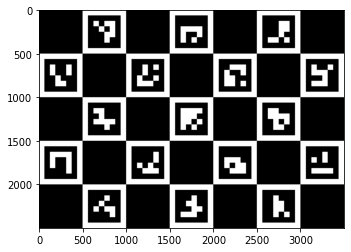

In [3]:
# create ChArUco
#@title Change to the actual measurement of the printout
squareLength = 0.04 #@param
markerLength = 0.03 #@param
dictionary = aruco.Dictionary_get(aruco.DICT_4X4_50)
board = aruco.CharucoBoard_create(7, 5, squareLength, markerLength, dictionary)
imboard = board.draw((3500, 2500))
cv2.imwrite('charuco_board.png', imboard)
plt.imshow(imboard, cmap='gray')
plt.show()

In [4]:
# inputs
cameraMatrix = np.loadtxt('intrinsic.txt')
distCoeffs = np.zeros(4)
image = cv2.imread('image.png')

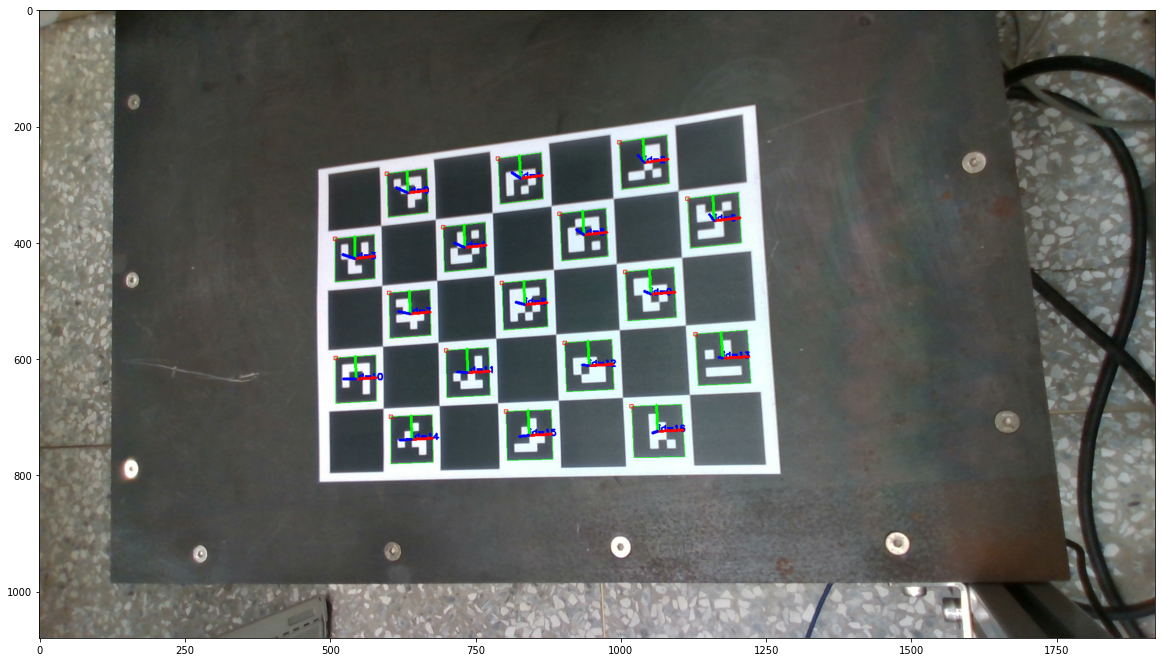

In [5]:
# detect markers
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, dictionary)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
for corner in corners:
  cv2.cornerSubPix(gray, corner, winSize = (3, 3), zeroZone = (-1, -1), criteria = criteria)
# draw markers
rvecs, tvecs, _objPoints = aruco.estimatePoseSingleMarkers(corners, markerLength, cameraMatrix, distCoeffs)
immarkers = aruco.drawDetectedMarkers(image.copy(), corners, ids)
# draw axis
for i in range(len(tvecs)):
  cv2.drawFrameAxes(immarkers, cameraMatrix, distCoeffs, rvecs[i], tvecs[i], markerLength/2)
immarkers_rgb = cv2.cvtColor(immarkers, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(immarkers_rgb)
plt.show()

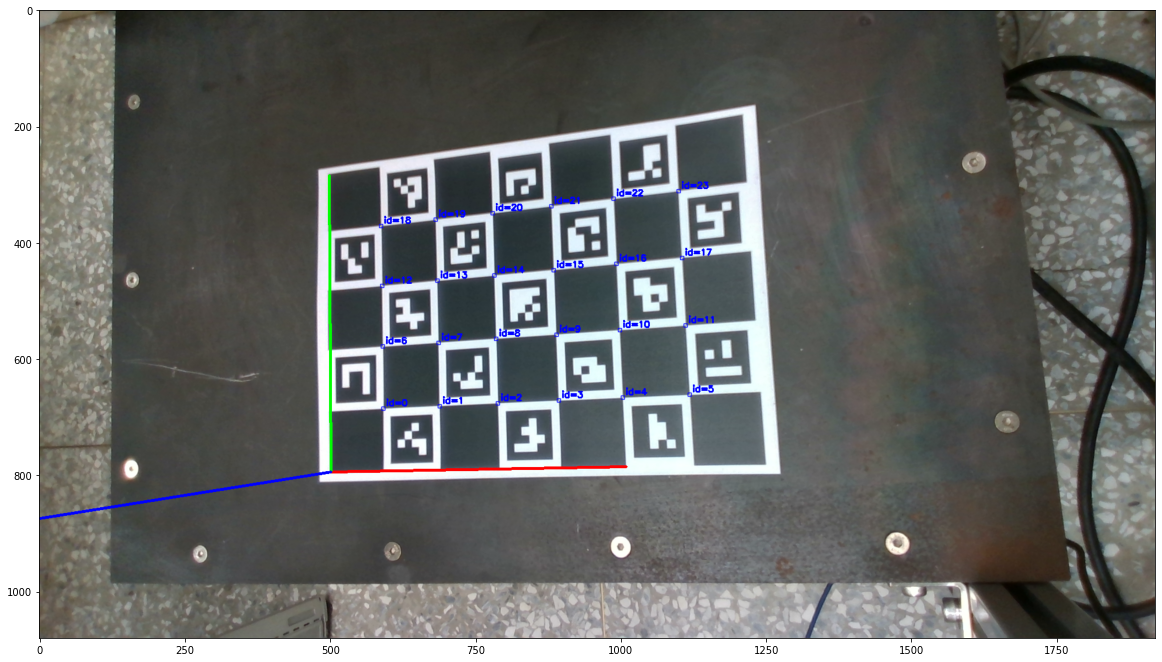

In [6]:
# detect charuco
retval, charucoCorners, charucoIds = aruco.interpolateCornersCharuco(corners, ids, gray, board, cameraMatrix, distCoeffs)
retval, rvec, tvec = aruco.estimatePoseCharucoBoard(charucoCorners, charucoIds, board, cameraMatrix, distCoeffs, None, None)
# draw corners
imcharuco = aruco.drawDetectedCornersCharuco(image.copy(), charucoCorners, charucoIds)
# draw axis
cv2.drawFrameAxes(imcharuco, cameraMatrix, distCoeffs, rvec, tvec, squareLength*5)
imcharuco_rgb = cv2.cvtColor(imcharuco, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(imcharuco_rgb)
plt.show()

In [7]:
# save output images
cv2.imwrite('markers.png', immarkers)
cv2.imwrite('charuco.png', imcharuco)

True

In [8]:
# output transformation matrix
rotation_matrix = cv2.Rodrigues(rvec)[0]
charuco_tf = np.concatenate((np.concatenate((rotation_matrix, tvec), axis=1), np.array([[0, 0, 0, 1]])))
print('charuco transformation matrix')
print(charuco_tf)
np.savetxt('charuco_tf.txt', charuco_tf)

camera_position = -np.matrix(rotation_matrix).T * np.matrix(tvec)
camera_tf = np.concatenate((np.concatenate((rotation_matrix.T, camera_position), axis=1), np.array([[0, 0, 0, 1]])))
print('camera transformation matrix = inverse of charuco transformation matrix')
print(camera_tf)
np.savetxt('camera_tf.txt', camera_tf)

charuco transformation matrix
[[ 0.95483032 -0.0422874  -0.29412723 -0.17033245]
 [-0.07304111 -0.99285416 -0.09436952  0.10475498]
 [-0.28803481  0.11159026 -0.95109598  0.51991143]
 [ 0.          0.          0.          1.        ]]
camera transformation matrix = inverse of charuco transformation matrix
[[ 0.95483032 -0.07304111 -0.28803481  0.3200426 ]
 [-0.0422874  -0.99285416  0.11159026  0.03878645]
 [-0.29412723 -0.09436952 -0.95109598  0.45427193]
 [ 0.          0.          0.          1.        ]]
